## Import Libraries


In [52]:
#!pip install pandas numpy matplotlib seaborn nltk textblob scikit-learn top2vec bertopic wordcloud

# !pip install top2vec
# !pip install bertopic
# !pip install gensim
# !pip install pyLDAvis

In [53]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Text processing and NLP
from textblob import TextBlob
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning and topic modeling
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

# from top2vec import Top2Vec
from bertopic import BERTopic

# Visualization
from wordcloud import WordCloud


# import gensim
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.corpora.dictionary import Dictionary

## Load the Dataset

Load the preprocessed cleantech media dataset


In [54]:
# Load the Dataset

# Load the preprocessed cpatent media dataset
# Load the dataset
file_path = "patent_preprocessed.csv"
patent_data = pd.read_csv(file_path, encoding="utf-8")

## Dataset Overview


In [55]:
# Display the first few rows and the data structure to understand what we have
# Display the first few rows and the data structure to understand what we have

patent_data.info()
patent_data.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8545 entries, 0 to 8544
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   publication_number     8545 non-null   object
 1   application_number     8545 non-null   object
 2   country_code           8545 non-null   object
 3   publication_date       8545 non-null   object
 4   title                  8545 non-null   object
 5   abstract               8545 non-null   object
 6   inventors              8545 non-null   object
 7   code                   8545 non-null   object
 8   inventive              8545 non-null   bool  
 9   first                  8545 non-null   bool  
 10  title_preprocessed     8395 non-null   object
 11  abstract_preprocessed  4552 non-null   object
dtypes: bool(2), object(10)
memory usage: 684.4+ KB


,publication_number,application_number,country_code,publication_date,title,abstract,inventors,code,inventive,first,title_preprocessed,abstract_preprocessed
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,[],H02M7/5395,True,False,adaptable DC AC Inverter Drive System Operation,Disclosed adaptable DC AC inverter system oper...


In [56]:
# Inspect the columns title_preprocessed and abstract_preprocessed for null values

patent_data.isnull().sum()

publication_number          0
application_number          0
country_code                0
publication_date            0
title                       0
abstract                    0
inventors                   0
code                        0
inventive                   0
first                       0
title_preprocessed        150
abstract_preprocessed    3993
dtype: int64

In [57]:
# Display the data dataframe head and tail

print(patent_data.head(2))

print(patent_data.tail(2))

# Filtering where abstract_preprocessed is null
filtered_data = patent_data[patent_data["abstract_preprocessed"].isnull()]

# Counting the occurrences of each country_code in the filtered data
country_code_counts = (
    filtered_data["country_code"].value_counts().sort_values(ascending=False)
)

# Display the counts
print(country_code_counts)

  publication_number application_number country_code publication_date  \
0   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
1   US-2022239251-A1  US-202217580956-A           US       2022-07-28   

                                               title  \
0  Adaptable DC-AC Inverter Drive System and Oper...   
1  System for providing the energy from a single ...   

                                            abstract inventors        code  \
0  Disclosed is an adaptable DC-AC inverter syste...        []  H02M7/5395   
1  In accordance with an example embodiment, a so...        []   H02S40/38   

   inventive  first                                 title_preprocessed  \
0       True  False    adaptable DC AC Inverter Drive System Operation   
1       True  False  system provide energy single contiguous solar ...   

                               abstract_preprocessed  
0  Disclosed adaptable DC AC inverter system oper...  
1  accordance example embodiment solar ener

### NLP Preprocessing Issue Report

**Background:**  
Our NLP framework encountered issues in effectively preprocessing multilingual patent data, particularly for Chinese (CN), Taiwanese (TW), and World Intellectual Property Organization (WO) codes, resulting in a substantial number of unprocessed entries.

**Potential Challenges Identified:**  
* **Model Limitations:** The spaCy Chinese model (`zh_core_web_sm`) may not fully capture the nuances of domain-specific Chinese used in patents, impacting the effectiveness of tokenization, lemmatization, and stop word removal.
* **Data Quality Issues:** Potential inaccuracies in language tagging and text quality could be leading to preprocessing failures.
* **Improper Text Handling:** The function may not handle specific cases well, leading to failures in text processing.

**New Observations:**  
* **Post-Export Null Values:** After saving the processed data to CSV and loading it back in for EDA, we have identified additional null values, which could be attributed to various reasons, including encoding issues, data export/import errors, or problems within the preprocessing pipeline itself. 

**Strategic Decision:**
* Despite these challenges, the decision has been made to not focus further on these issues. We will continue with our project's next steps and shift our resources towards progressing. This issue will be further investigated in the future to determine the root cause and implement necessary fixes.


In [58]:
# Drop the rows with missing values in abstract_preprocessed and title_preprocessed

patent_data = patent_data.dropna(subset=["abstract_preprocessed", "title_preprocessed"])

# Checking the shape of the dataframe

print(patent_data.shape)

(4470, 12)


### General Text Statistics

We'll compute:

* Average word count of titles and contents.
* Distribution of article lengths.
* The most common words before diving into more complex analysis like sentiment and topics


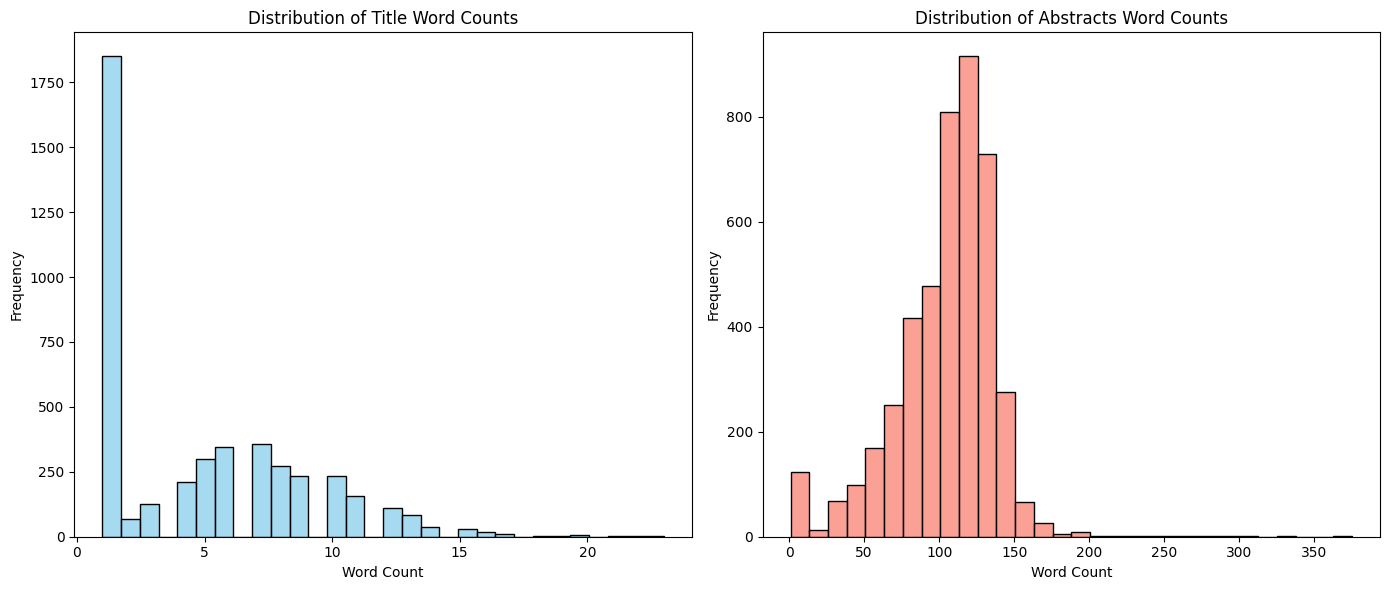

(count    4470.000000
 mean        4.902237
 std         4.104265
 min         1.000000
 25%         1.000000
 50%         4.000000
 75%         8.000000
 max        23.000000
 Name: word_count_title, dtype: float64,
 count    4470.000000
 mean      104.516107
 std        33.526871
 min         1.000000
 25%        88.000000
 50%       111.000000
 75%       126.000000
 max       375.000000
 Name: word_count_abstract, dtype: float64)

In [59]:
# Basic text statistics
patent_data["word_count_title"] = patent_data["title_preprocessed"].apply(
    lambda x: len(x.split())
)
patent_data["word_count_abstract"] = patent_data["abstract_preprocessed"].apply(
    lambda x: len(x.split())
)

# Plotting the distribution of word counts
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(patent_data["word_count_title"], bins=30, ax=ax[0], color="skyblue")
ax[0].set_title("Distribution of Title Word Counts")
ax[0].set_xlabel("Word Count")
ax[0].set_ylabel("Frequency")

sns.histplot(patent_data["word_count_abstract"], bins=30, ax=ax[1], color="salmon")
ax[1].set_title("Distribution of Abstracts Word Counts")
ax[1].set_xlabel("Word Count")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Calculate and display basic statistics
title_stats = patent_data["word_count_title"].describe()
content_stats = patent_data["word_count_abstract"].describe()

title_stats, content_stats

### Text Analysis Report

**Titles:**

* **Average Word Count:** 4.90 words
* **Standard Deviation:** 4.10 words
* **Minimum Word Count:** 1 word
* **Maximum Word Count:** 23 words
* **Observations:** The titles in the dataset tend to be concise, averaging around 5 words per title. The histogram would likely show a broad distribution, with a significant number of titles at the lower end but some extending to 23 words, indicating a variety in the brevity and detail of titles.

**Abstracts:**

* **Average Word Count:** 104.52 words
* **Standard Deviation:** 33.53 words
* **Minimum Word Count:** 1 word
* **Maximum Word Count:** 375 words
* **Observations:** The content of the abstracts is considerably longer than the titles, with more variation in length. Most document contents are around 104 words on average, with standard abstract length ranging broadly from 71 to 138 words, reflecting moderate detail in discussions.


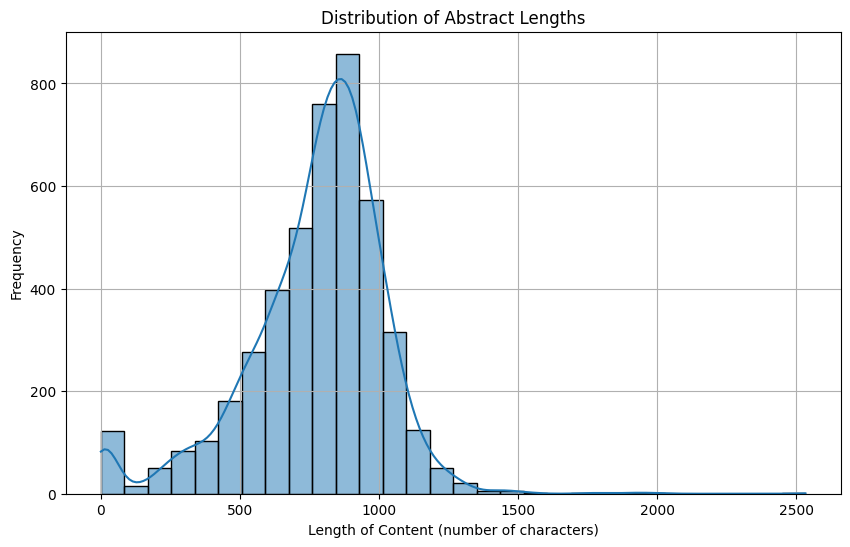

In [60]:
# Calculate the length of each document
patent_data["abstract_length"] = patent_data["abstract_preprocessed"].apply(len)

# Plot the distribution of document lengths
plt.figure(figsize=(10, 6))
sns.histplot(patent_data["abstract_length"], bins=30, kde=True)
plt.title("Distribution of Abstract Lengths")
plt.xlabel("Length of Content (number of characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram above shows the distribution of abstract lengths in terms of the number of characters in the preprocessed content. The distribution appears to be slightly skewed left, indicating that most abstracts are of a moderate length, with fewer articles being significantly longer.


## Number of Patent Publications Over Time


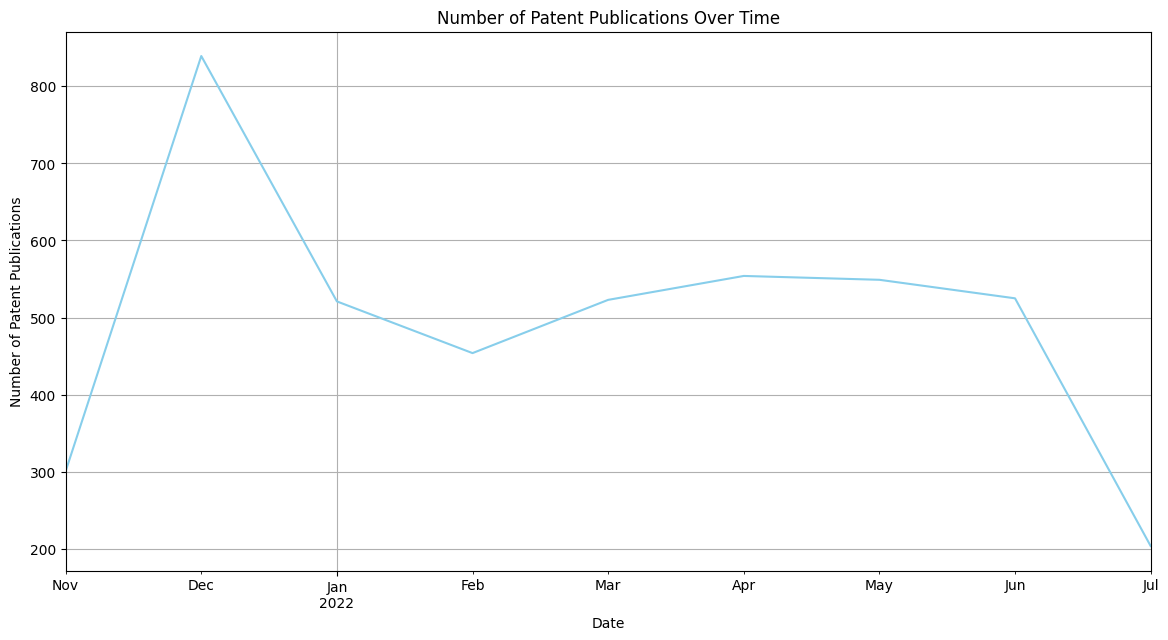

In [61]:
# Convert 'publication_date' to datetime format
patent_data["publication_date"] = pd.to_datetime(
    patent_data["publication_date"])

# Set 'publication_date' as the index
patent_data.set_index("publication_date", inplace=True)

# Resample and count publications per month
monthly_counts = patent_data.resample("M").size()

# Plotting
plt.figure(figsize=(14, 7))
monthly_counts.plot(
    title="Number of Patent Publications Over Time", color="skyblue")
plt.xlabel("Date")
plt.ylabel("Number of Patent Publications")
plt.grid(True)
plt.show()

In [70]:
# display column

patent_data.columns

patent_data.head(1)

,publication_number,application_number,country_code,title,abstract,inventors,code,inventive,first,title_preprocessed,abstract_preprocessed,word_count_title,word_count_abstract,abstract_length,sentiment_polarity,sentiment_subjectivity
publication_date,,,,,,,,,,,,,,,,
2022-07-28,US-2022239235-A1,US-202217717397-A,US,Adaptable DC-AC Inverter Drive System and Oper...,Disclosed is an adaptable DC-AC inverter syste...,[],H02M7/5395,True,False,adaptable DC AC Inverter Drive System Operation,Disclosed adaptable DC AC inverter system oper...,7,39,279,0.0,0.0


## Word Frequency Analysis


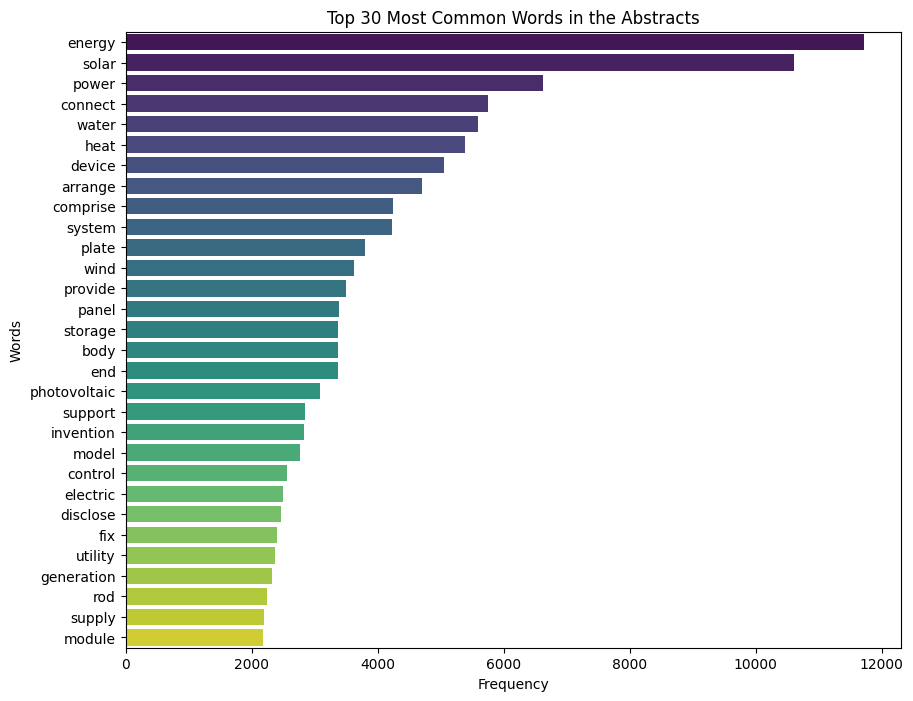

In [63]:
# Function to count word frequency
def count_words(text_series):
    word_counts = Counter()
    for text in text_series:
        word_counts.update(text.split())
    return word_counts


# Count words in the preprocessed content
word_freq = count_words(patent_data["abstract_preprocessed"])

# Convert to a DataFrame for visualization
word_freq_df = pd.DataFrame(word_freq.most_common(
    30), columns=["word", "frequency"])

# Plotting the top 30 words
plt.figure(figsize=(10, 8))
sns.barplot(x="frequency", y="word", data=word_freq_df, palette="viridis")
plt.title("Top 30 Most Common Words in the Abstracts")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

## Bigram Analysis


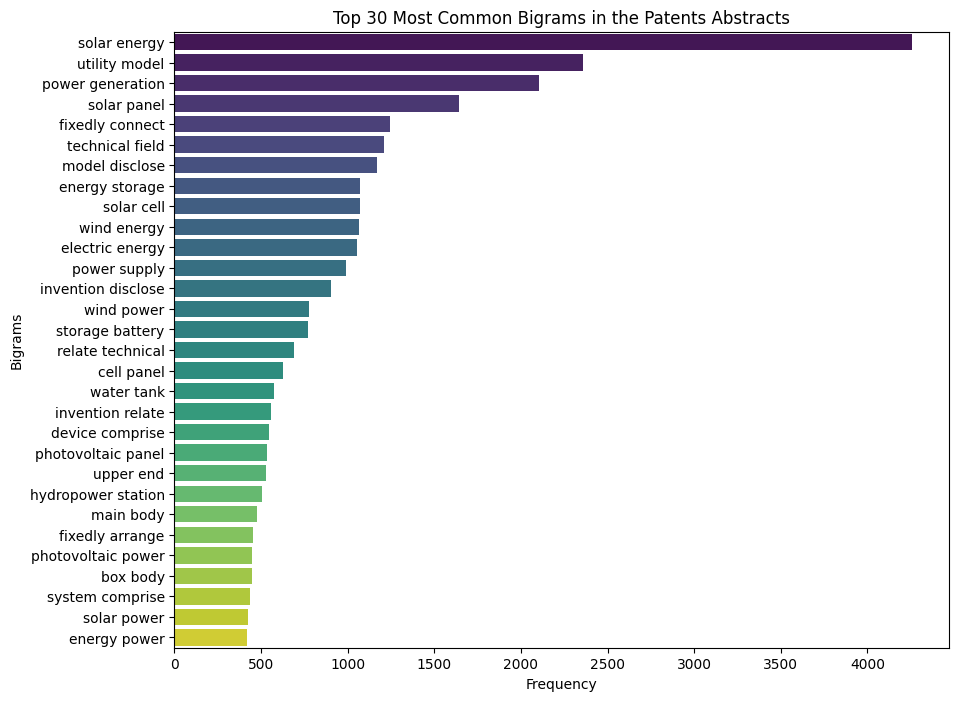

In [64]:
# Function to count bigrams
def count_bigrams(text_series):
    bigram_counts = Counter()
    for text in text_series:
        bigrams = ngrams(text.split(), 2)
        bigram_counts.update(bigrams)
    return bigram_counts


# Count bigrams in the preprocessed content
bigram_freq = count_bigrams(patent_data["abstract_preprocessed"])


# Convert to a DataFrame for visualization
bigram_freq_df = pd.DataFrame(
    bigram_freq.most_common(30), columns=["bigram", "frequency"]
)
bigram_freq_df["bigram"] = bigram_freq_df["bigram"].apply(
    lambda x: " ".join(x))

# Plotting the top 30 bigrams
plt.figure(figsize=(10, 8))
sns.barplot(x="frequency", y="bigram", data=bigram_freq_df, palette="viridis")
plt.title("Top 30 Most Common Bigrams in the Patents Abstracts")
plt.xlabel("Frequency")
plt.ylabel("Bigrams")
plt.show()

## Word Cloud


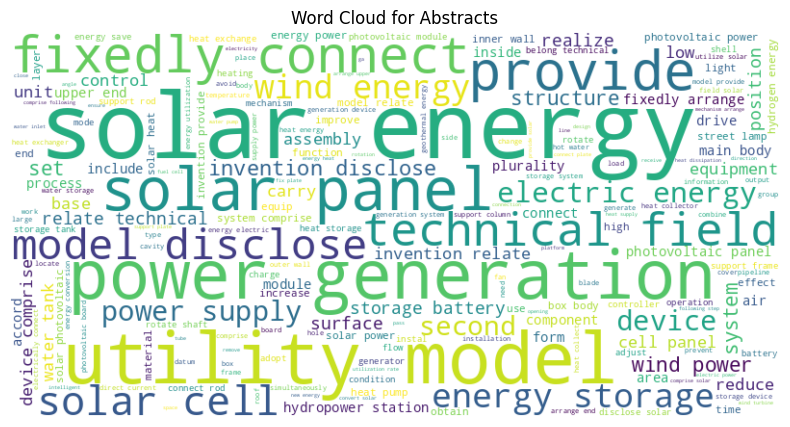

In [65]:
# Generate a word cloud for the 'content_preprocessed'
content_text = " ".join(patent_data["abstract_preprocessed"].dropna())
wordcloud_content = WordCloud(width=800, height=400, background_color="white").generate(
    content_text
)

# Display the word cloud for content
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_content, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Abstracts")
plt.show()


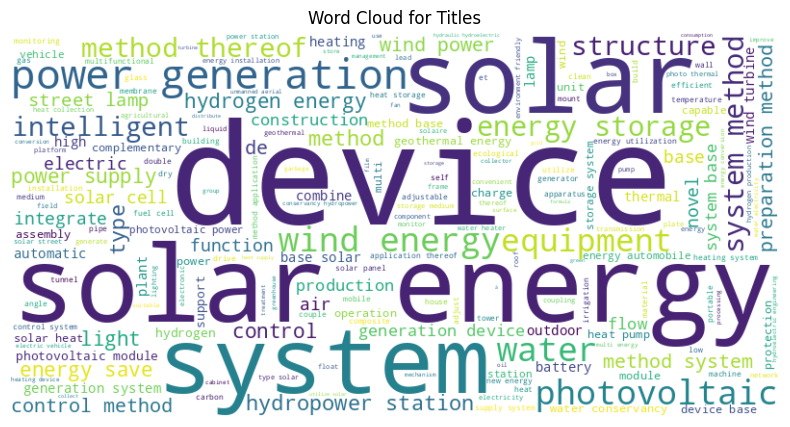

In [66]:
# Generate a word cloud for the 'content_preprocessed'
content_text = " ".join(patent_data["title_preprocessed"].dropna())
wordcloud_content = WordCloud(width=800, height=400, background_color="white").generate(
    content_text
)

# Display the word cloud for content
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_content, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Titles")
plt.show()


In [71]:
patent_data.index

DatetimeIndex(['2022-07-28', '2022-07-28', '2022-07-27', '2022-07-26',
               '2022-07-21', '2022-07-21', '2022-07-21', '2022-07-21',
               '2022-07-21', '2022-07-21',
               ...
               '2021-11-23', '2021-11-23', '2021-11-23', '2021-11-23',
               '2021-11-23', '2021-11-23', '2021-11-23', '2021-11-23',
               '2021-11-23', '2021-11-23'],
              dtype='datetime64[ns]', name='publication_date', length=4470, freq=None)

## Sentiment Analysis


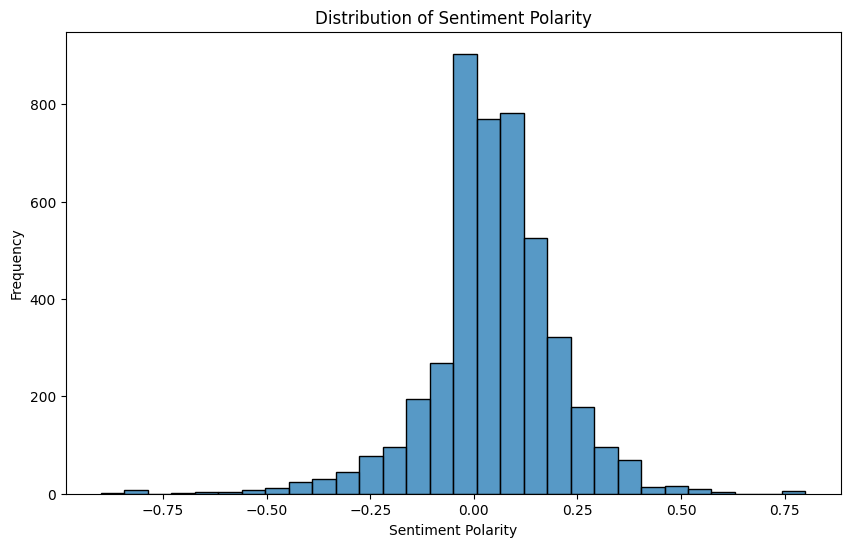

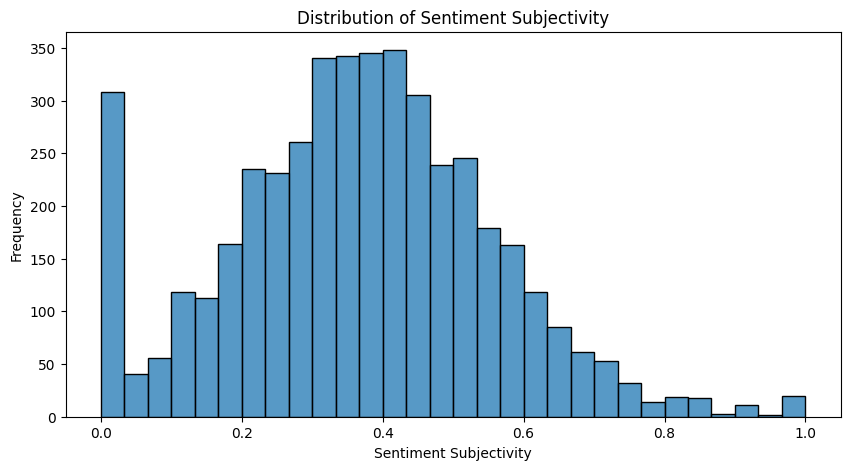

In [67]:
# Function to calculate sentiment polarity and subjectivity
def calculate_sentiment(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.polarity, sentiment.subjectivity


# Calculate sentiment polarity and subjectivity for each article
patent_data["sentiment_polarity"], patent_data["sentiment_subjectivity"] = zip(
    *patent_data["abstract_preprocessed"].apply(calculate_sentiment)
)

# Plot the distribution of sentiment polarities
plt.figure(figsize=(10, 6))
sns.histplot(patent_data["sentiment_polarity"], bins=30, kde=False)
plt.title("Distribution of Sentiment Polarity")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

# Plot the distribution of sentiment subjectivities
plt.figure(figsize=(10, 5))
sns.histplot(patent_data["sentiment_subjectivity"], bins=30, kde=False)
plt.title("Distribution of Sentiment Subjectivity")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Frequency")
plt.show()

In [68]:
# display column

patent_data.columns


Index(['publication_number', 'application_number', 'country_code', 'title',
       'abstract', 'inventors', 'code', 'inventive', 'first',
       'title_preprocessed', 'abstract_preprocessed', 'word_count_title',
       'word_count_abstract', 'abstract_length', 'sentiment_polarity',
       'sentiment_subjectivity'],
      dtype='object')

##  Time Series Plot for Polarity and Subjectivity Over Time


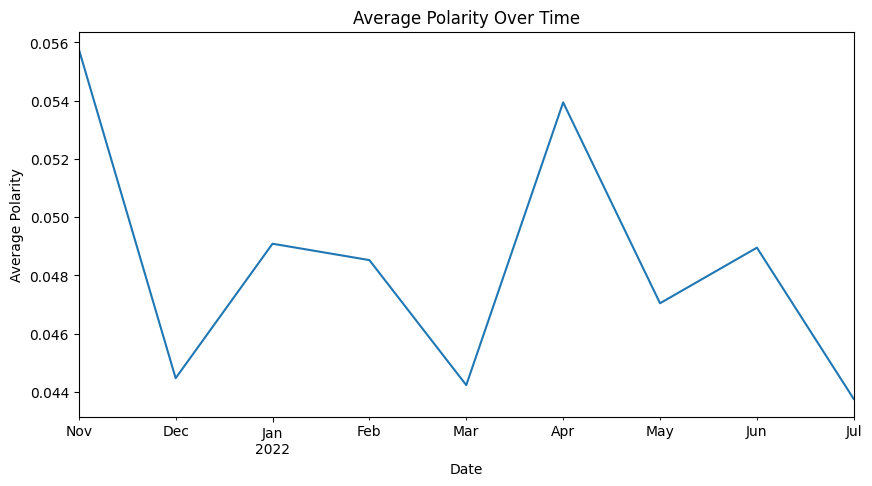

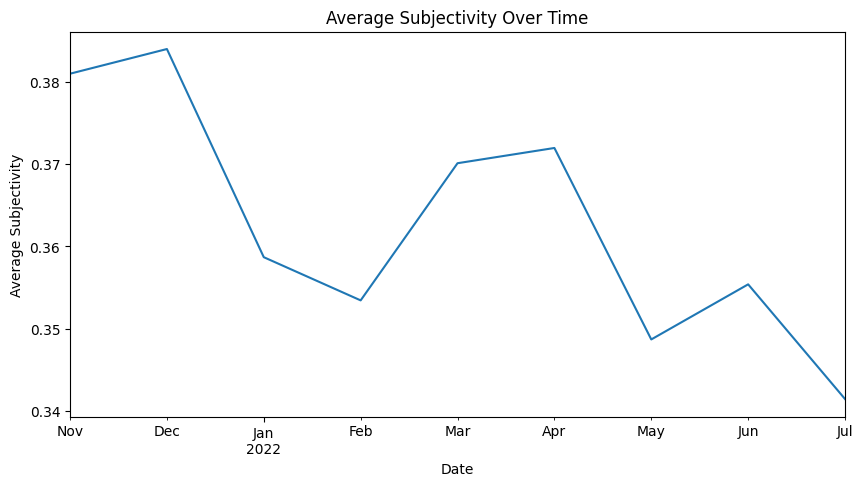

In [75]:
# Group by 'Date', resample by month, and calculate mean for numeric columns only

grouped_data = patent_data.resample("M")[
    ["sentiment_polarity", "sentiment_subjectivity"]
].mean()

# Plot Polarity and Subjectivity over time

# Polarity over time
plt.figure(figsize=(10, 5))
grouped_data["sentiment_polarity"].plot(title="Average Polarity Over Time")
plt.xlabel("Date")
plt.ylabel("Average Polarity")
plt.show()

# Subjectivity over time
plt.figure(figsize=(10, 5))
grouped_data["sentiment_subjectivity"].plot(title="Average Subjectivity Over Time")
plt.xlabel("Date")
plt.ylabel("Average Subjectivity")
plt.show()

## Scatter Plot Between Polarity and Subjectivity:

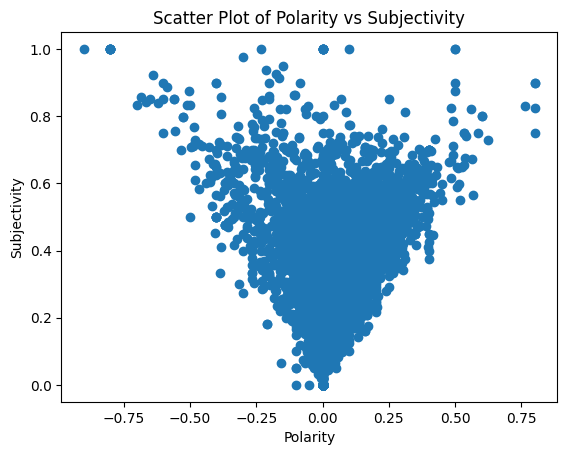

In [76]:
plt.scatter(patent_data["sentiment_polarity"], patent_data["sentiment_subjectivity"])
plt.title("Scatter Plot of Polarity vs Subjectivity")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.show()